# SIRD Model Calibration with 90-Day Epidemic Data

This notebook implements a SIRD (Susceptible, Infectious, Recovered, Deceased) model to simulate epidemic dynamics. We use a grid search to calibrate the model parameters by comparing simulation results with real-world data for 90 days.

The notebook is organized as follows:

1. **Imports and Setup:** Import required libraries.
2. **Utility Functions:** Define functions for RMSE computation.
3. **Model Functions:** Implement the SIRD forecast (Euler integration).
4. **Grid Search:** Optimize the SIRD parameters.
5. **Visualization:** Plot the simulation results against the ground truth.
6. **Main Execution:** Load data, set initial conditions, run grid search, and display the results.

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from tqdm.contrib.itertools import product

# Optionally, uncomment the following line if you want inline plotting in Jupyter Notebook:
# %matplotlib inline

## 1. Utility Functions

We start by defining a function to compute the Root Mean Square Error (RMSE) between model predictions and the observed data.

In [33]:
def rmse(model_prediction, true_values):
    nb_samples = len(model_prediction)
    total_squared_errors = 0
    for i in range(nb_samples):
        total_squared_errors += (model_prediction[i] - true_values[i]) ** 2
    return math.sqrt(total_squared_errors / nb_samples)

## 2. Model Functions

We define the SIRD forecast function. This function uses Euler’s method to simulate the SIRD model dynamics over a specified period.

The SIRD differential equations are:

\[
\frac{dS}{dt} = -\beta\,S\,I, \quad \frac{dI}{dt} = \beta\,S\,I - \gamma\,I - \mu\,I, \quad \frac{dR}{dt} = \gamma\,I, \quad \frac{dD}{dt} = \mu\,I
\]

In [34]:
def sird_forecast(beta, gamma, mu, step, nb_jours, init_conditions):
    """
    Simulate the SIRD model using Euler integration.
    
    Parameters:
        beta, gamma, mu : float
            Model parameters.
        step : float
            Time step for simulation (in days).
        nb_jours : int
            Total number of days for simulation.
        init_conditions : dict
            Initial conditions for S, I, R, D.
            
    Returns:
        time : array of time points (downsampled)
        S, I, R, D : arrays of the simulated compartment values (downsampled)
    """
    time = [0]
    S = [init_conditions["S"]]
    I = [init_conditions["I"]]
    R = [init_conditions["R"]]
    D = [init_conditions["D"]]
    
    nb_points = int(nb_jours / step)
    
    for _ in range(1, nb_points):
        s_current = S[-1]
        i_current = I[-1]
        r_current = R[-1]
        d_current = D[-1]
        
        ds = -beta * s_current * i_current
        di = beta * s_current * i_current - gamma * i_current - mu * i_current
        dr = gamma * i_current
        dd = mu * i_current
        
        S.append(s_current + ds * step)
        I.append(i_current + di * step)
        R.append(r_current + dr * step)
        D.append(d_current + dd * step)
        time.append(time[-1] + step)
    
    # Downsample the simulation output to match daily data (90 days)
    # With step=0.001 and nb_jours=90, there are 90,000 points.
    # Downsampling by a factor of 1000 yields 90 points.
    ds_factor = int(1 / step)  # e.g., 1000 if step=0.001
    time = np.array(time[::ds_factor])
    S = np.array(S[::ds_factor])
    I = np.array(I[::ds_factor])
    R = np.array(R[::ds_factor])
    D = np.array(D[::ds_factor])
    return time, S, I, R, D

## 3. Grid Search for Parameter Calibration

We use a grid search to find the best combination of parameters (β, γ, μ) that minimizes the error between our simulation and the real data. For each combination, we simulate the model and compute the RMSE across all compartments.

In [35]:
def grid_search_sird(step, nb_jours, ground_truth, init_conditions):
    # Define parameter ranges - adjust these ranges as necessary for your data.
    betas = np.linspace(0.1, 1, 20)
    gammas = np.linspace(0.1, 1, 4)
    mus = np.linspace(0.01, 0.5, 4)
    
    best_beta, best_gamma, best_mu = None, None, None 
    best_rmse = float("inf")
    
    for beta, gamma, mu in product(betas, gammas, mus):
        time, S, I, R, D = sird_forecast(beta, gamma, mu, step, nb_jours, init_conditions)
        rmse_S = rmse(S, ground_truth["Susceptibles"].values)
        rmse_I = rmse(I, ground_truth["Infectés"].values)
        rmse_R = rmse(R, ground_truth["Rétablis"].values)
        rmse_D = rmse(D, ground_truth["Décès"].values)
        total_rmse = rmse_S + rmse_I + rmse_R + rmse_D
        
        if total_rmse < best_rmse:
            best_rmse = total_rmse
            best_beta, best_gamma, best_mu = beta, gamma, mu
            
    print("Best parameters found:")
    print("beta:", best_beta, "gamma:", best_gamma, "mu:", best_mu)
    
    # Run simulation with best parameters for plotting.
    time, best_S, best_I, best_R, best_D = sird_forecast(best_beta, best_gamma, best_mu, step, nb_jours, init_conditions)
    return time, best_S, best_I, best_R, best_D

## 4. Visualization

We define a function to plot both the model predictions and the ground truth data.

In [36]:
def plot_sird(time, S, I, R, D, ground_truth):
    plt.figure(figsize=(15, 6))
    
    # Plot model predictions
    plt.plot(time, S, "b", label='Susceptibles (predicted)')
    plt.plot(time, I, "r", label='Infectés (predicted)')
    plt.plot(time, R, "g", label='Rétablis (predicted)')
    plt.plot(time, D, "k", label='Décès (predicted)')
    
    # Plot ground truth data (ensure that the "Jour" column matches simulation time)
    plt.plot(ground_truth["Jour"], ground_truth["Susceptibles"], "b--", label='Susceptibles (real)')
    plt.plot(ground_truth["Jour"], ground_truth["Infectés"], "r--", label='Infectés (real)')
    plt.plot(ground_truth["Jour"], ground_truth["Rétablis"], "g--", label='Rétablis (real)')
    plt.plot(ground_truth["Jour"], ground_truth["Décès"], "k--", label='Décès (real)')
    
    plt.xlabel('Temps (Jours)')
    plt.ylabel('Population Fraction')
    plt.title('Modélisation SIRD vs. Données Réelles')
    plt.legend()
    plt.show()

## 5. Main Execution

In this section, we load the dataset (which has 90 days of data), set the initial conditions, run the grid search to calibrate the model, and then visualize the results.

**Note:** Ensure your CSV file contains 90 rows (one per day) and has columns labeled `Jour`, `Susceptibles`, `Infectés`, `Rétablis`, and `Décès`.

100%|██████████| 320/320 [01:27<00:00,  3.65it/s]


Best parameters found:
beta: 0.33684210526315794 gamma: 0.1 mu: 0.01


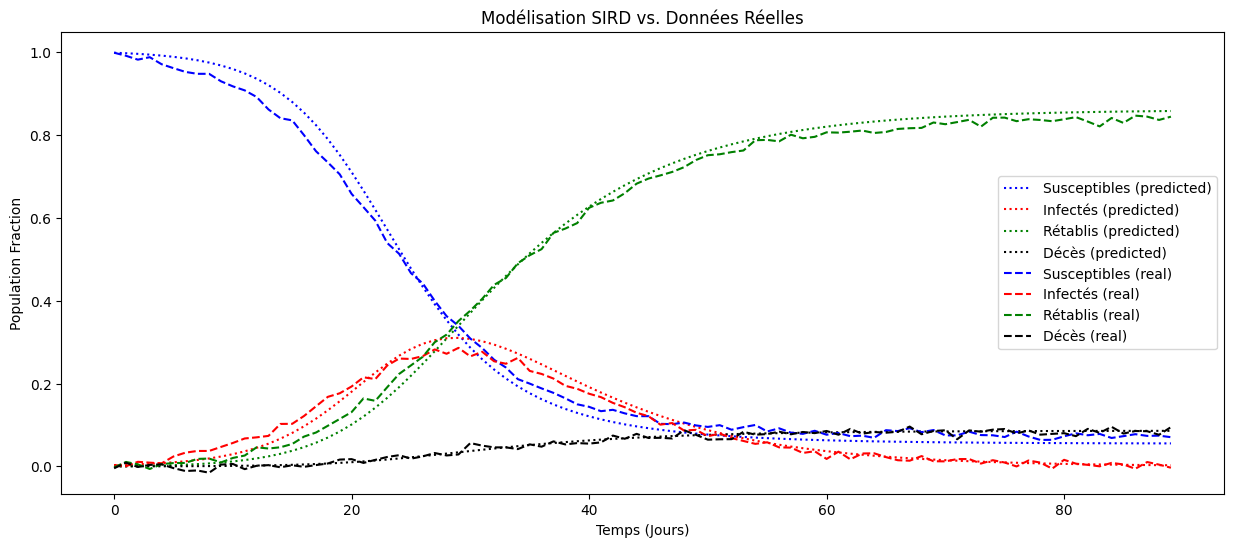

In [38]:
if __name__ == "__main__":
    step = 0.001    # time step in days
    nb_jours = 90   # simulation duration (90 days)
    
    # Load ground truth data from CSV (update the path accordingly)
    ground_truth = pd.read_csv("D:\school\HETIC\PYTHON\dev back\Lotka-Volterra\LotkaVolterra\sird_dataset.csv")
    
    # Define initial conditions.
    # Here we assume the first row (Jour == 0) holds the starting values for Susceptibles and Infectés.
    # For Rétablis and Décès, if the data has negative or unrealistic initial values, set them to 0.
    init_conditions = {
        "S": ground_truth.loc[ground_truth["Jour"] == 0, "Susceptibles"].values[0],
        "I": ground_truth.loc[ground_truth["Jour"] == 0, "Infectés"].values[0],
        "R": 0,  # or use ground_truth value if appropriate
        "D": 0   # or use ground_truth value if appropriate
    }
    
    # Run grid search to find best model parameters and simulate the epidemic dynamics.
    time, best_S, best_I, best_R, best_D = grid_search_sird(step, nb_jours, ground_truth, init_conditions)
    
    # Plot the simulation results alongside the ground truth.
    plot_sird(time, best_S, best_I, best_R, best_D, ground_truth)

## Conclusion

In this notebook, we:

- Implemented the SIRD model using Euler integration.
- Calibrated the model parameters using a grid search approach over 90 days of epidemic data.
- Visualized the model predictions against the actual data.

Adjust the parameter ranges, step size, or initial conditions as needed for further refinements.